# **KDD-99 dataset Study with K-mean algorithm**
group 4 

## Table of content

1.   Dataset exploration.
2.   Machine Learning studies : K-means.
        *   Basic features.
        *   Basic and content features.
        *   All continous features.
        *   Other bunch of code.





In [ ]:
#basic lib import
import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt

#import lib to link my google drive to the notebook
from google.colab import drive

#for machine learning studies
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale

#for correlation plot
import seaborn as sns



In [ ]:
drive.mount("/content/drive")

Mounted at /content/drive




---



## Data Set exploration

In [ ]:
data = pd.read_table("/content/drive/MyDrive/Colab Notebooks/AIC/kddcup.data_10_percent_corrected",delimiter=",",header=None)
print(data.shape)

(494021, 42)


In [ ]:
column_name = ["duration",
"protocol_type",
"service",
"flag",
"src_bytes",
"dst_bytes",
"land",
"wrong_fragment",
"urgent",
"hot",
"num_failed_logins",
"logged_in",
"num_compromised",
"root_shell",
"su_attempted",
"num_root",
"num_file_creations",
"num_shells",
"num_access_files",
"num_outbound_cmds",
"is_host_login",
"is_guest_login",
"count",
"srv_count",
"serror_rate",
"srv_serror_rate",
"rerror_rate",
"srv_rerror_rate",
"same_srv_rate",
"diff_srv_rate",
"srv_diff_host_rate",
"dst_host_count",
"dst_host_srv_count",
"dst_host_same_srv_rate",
"dst_host_diff_srv_rate",
"dst_host_same_src_port_rate",
"dst_host_srv_diff_host_rate",
"dst_host_serror_rate",
"dst_host_srv_serror_rate",
"dst_host_rerror_rate",
"dst_host_srv_rerror_rate",
"label"]

In [ ]:
#we add column to the header of our dataframe
data.columns = column_name
data.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,http,SF,181,5450,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,9,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,239,486,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,19,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,235,1337,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,29,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,219,1337,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.0,0.0,0.0,0.0,1.0,0.0,0.0,39,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.0,0.0,0.0,0.0,1.0,0.0,0.0,49,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.


In [ ]:
data.dtypes

duration                         int64
protocol_type                   object
service                         object
flag                            object
src_bytes                        int64
dst_bytes                        int64
land                             int64
wrong_fragment                   int64
urgent                           int64
hot                              int64
num_failed_logins                int64
logged_in                        int64
num_compromised                  int64
root_shell                       int64
su_attempted                     int64
num_root                         int64
num_file_creations               int64
num_shells                       int64
num_access_files                 int64
num_outbound_cmds                int64
is_host_login                    int64
is_guest_login                   int64
count                            int64
srv_count                        int64
serror_rate                    float64
srv_serror_rate          

42 features made of categorical and continous variables. First we are going to make sure that there are no missing values. Thus it will save us some preproccessing time 

In [ ]:
data.isnull().values.any()

False

No missing values. that is a very good point



---



Then we are going to dive deeper in Object variables to understand the full dataset

In [ ]:
protocol_type = data["protocol_type"]
protocol_type_OHE = pd.get_dummies(protocol_type)
protocol_type_OHE.sum()

icmp    283602
tcp     190065
udp      20354
dtype: int64

In [ ]:
service = data.service
service_OHE = pd.get_dummies(service)
print(service_OHE.sum())

IRC           43
X11           11
Z39_50        92
auth         328
bgp          106
            ... 
urp_i        538
uucp         106
uucp_path    106
vmnet        106
whois        110
Length: 66, dtype: int64


In [ ]:
flag = data.flag
flag_OHE = pd.get_dummies(flag)
flag_OHE.sum()

OTH            8
REJ        26875
RSTO         579
RSTOS0        11
RSTR         903
S0         87007
S1            57
S2            24
S3            10
SF        378440
SH           107
dtype: int64

In [ ]:
label_set = data.label
label_set_OHE = pd.get_dummies(label_set)
label_set_OHE.sum()

back.                 2203
buffer_overflow.        30
ftp_write.               8
guess_passwd.           53
imap.                   12
ipsweep.              1247
land.                   21
loadmodule.              9
multihop.                7
neptune.            107201
nmap.                  231
normal.              97278
perl.                    3
phf.                     4
pod.                   264
portsweep.            1040
rootkit.                10
satan.                1589
smurf.              280790
spy.                     2
teardrop.              979
warezclient.          1020
warezmaster.            20
dtype: int64

Then we transforming this String data into Integer data. We decided to not use one hot encoding because we are not going to use non continous variables in the first time.

In [ ]:
#transforming string to int for categorical features
data['protocol_type'] = pd.factorize(data['protocol_type'])[0].astype(np.int64)
data['service'] = pd.factorize(data['service'])[0].astype(np.int64)
data['flag'] = pd.factorize(data['flag'])[0].astype(np.int64)
data['label'] = pd.factorize(data['label'])[0].astype(np.int64)

We decided to create 3 different data set made of basic, content and traffic feature. This will allow us to start our study with simpler dataset.

In [ ]:
X = data.drop(columns=["label"])
traffic_features = X[["count","srv_count","serror_rate","srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate","diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count","dst_host_serror_rate","dst_host_srv_serror_rate","dst_host_rerror_rate","dst_host_srv_rerror_rate","dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_srv_diff_host_rate","dst_host_same_src_port_rate"]]
basic_features = X[["duration","protocol_type","service","flag","src_bytes","dst_bytes","land","wrong_fragment","urgent"]]
content_features = X[["hot","num_failed_logins","logged_in","num_compromised","root_shell","su_attempted","num_root","num_file_creations","num_shells","num_access_files","num_outbound_cmds","is_host_login","is_guest_login"]]



---



## Machine Learning studies : K-mean


Functions that are going to be used in our study

In [ ]:
#kmeans algorithm
def Kmeans_model(X,number_of_clusters,number_init):
  distorsions = []
  for k in number_of_clusters:
    print(k)
    kmeans = KMeans(n_clusters=k,n_init=number_init)
    kmeans.fit(X)
    distorsions.append(kmeans.inertia_)

  if (len(number_of_clusters)>1): #only when we are testing more than one cluster setting
    fig = plt.figure(figsize=(15, 5))
    plt.plot(number_of_clusters, distorsions)
    plt.grid(True)
    plt.title('Elbow curve distorsion')
    
  return distorsions

#function that returns a list composed of the number of normal data in each cluster
def kmean_label_study(y,model_label,nb_clusters):
  normal_data_in_cluster = np.array(np.zeros(nb_clusters))
  for i in range(len(y)):
    if(y[i]==0):
      normal_data_in_cluster[model_label[i]] += 1
  return normal_data_in_cluster


In [ ]:
#correlation plot
def plot_corr(corr):
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    sns.heatmap(corr, mask=mask, cmap=cmap)

    sns.set_style('darkgrid')
    plt.rc('figure', figsize=[8, 6])

First we start with simple dataset. We are going to use only basic features to implement our model. (variables from the first table on the kdd_99 website). \
On top of that we are going to use only continous variables. The kmeans algorithm is using euclidian distance to compute the distance between data and their cluster centroid. Thus it is not possible to use discrete variables in our study because it do not take in account the data repartition that is crucial for discrete variables. (mahalanobis distance would have been better)

### Basic features

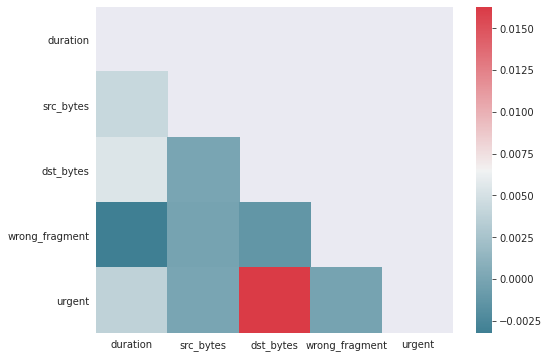

In [ ]:
corr_basic_feature = basic_features[["duration","src_bytes","dst_bytes","wrong_fragment","urgent"]].corr()
plot_corr(corr_basic_feature)

no strong correlation within data -> euclidian distance is interresting in that case

In [ ]:
continous_basic_features = basic_features[["duration","src_bytes","dst_bytes","wrong_fragment","urgent"]]

we scale our data

In [ ]:
continous_basic_features_centered = pd.DataFrame(scale(continous_basic_features),columns = continous_basic_features.columns)
continous_basic_features_centered.describe()

,duration,src_bytes,dst_bytes,wrong_fragment,urgent
count,4.940210e+05,4.940210e+05,4.940210e+05,4.940210e+05,4.940210e+05
mean,-3.625574e-14,-1.320064e-14,-5.498890e-14,-6.073146e-15,-1.529804e-14
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-6.779172e-02,-3.061686e-03,-2.628733e-02,-4.772019e-02,-2.571468e-03
25%,-6.779172e-02,-3.016149e-03,-2.628733e-02,-4.772019e-02,-2.571468e-03
50%,-6.779172e-02,-2.535486e-03,-2.628733e-02,-4.772019e-02,-2.571468e-03
75%,-6.779172e-02,-2.017381e-03,-2.628733e-02,-4.772019e-02,-2.571468e-03
max,8.234740e+01,7.016400e+02,1.560110e+02,2.220663e+01,5.444371e+02


We run our Kmean algorithm with clusters number between 3 and 40. Then we will use the elbow curve to find the proper Kmean settings in that case

3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


[1498518.8161031706,
 1080169.6497338733,
 668366.0315855964,
 329177.8918015903,
 251541.45078664436,
 191075.34751041766,
 134795.4566393842,
 98284.13869656307,
 79797.0755535329,
 63243.33455640076,
 48503.704692977626,
 39329.78641676955,
 31637.243702335385,
 26962.733928724283,
 22497.74723137214,
 20043.54551100838,
 17748.946095460517,
 15524.082112552876,
 13244.026864777674,
 11336.389167036257,
 9841.634056610177,
 8596.727792557911,
 7692.520796765036,
 6793.894312317424,
 6097.693507315275,
 5331.610282451513,
 4902.6476262328315,
 4466.23275580906,
 4193.3504746100825,
 3815.16400392741,
 3572.6571465802535,
 3335.2120068213635,
 3143.1583071447562,
 2944.9173568465008,
 2727.912666138681,
 2553.055813631123,
 2396.0006904068587]

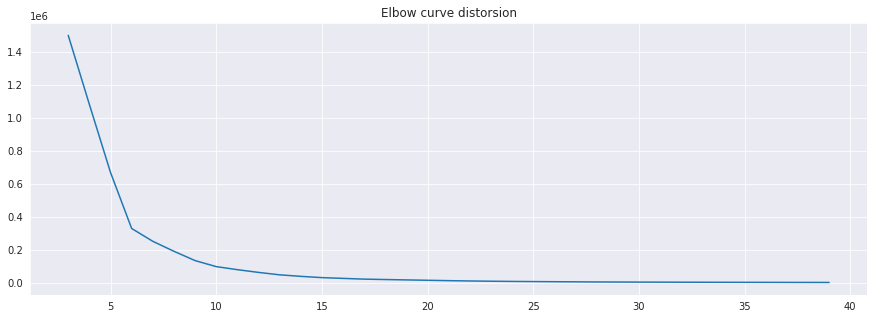

In [ ]:
number_of_clusters = np.arange(3,40)
number_init = 15
Kmeans_model(continous_basic_features_centered,number_of_clusters,number_init)

According to the elbow curve plot, **10** clusters is sufficient 

We dive deeper into clustters information in order to highlight unproper behaviours in our clusters.

In [ ]:
NB_clusters = 10
model = KMeans(n_clusters=NB_clusters, n_init=20)
model.fit(continous_basic_features_centered)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=20, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [ ]:
model_labels = model.labels_
cluster_summary = pd.DataFrame(pd.get_dummies(model_labels).sum(), columns=["Nb_data_in_cluster"])
cluster_summary["Nb_normal_in_cluster"] = kmean_label_study(data["label"],model_labels,NB_clusters)
cluster_summary["Nb_anormal_in_cluster"] = (cluster_summary["Nb_data_in_cluster"] - cluster_summary["Nb_normal_in_cluster"])
cluster_summary["%_normal_in_cluster"] = kmean_label_study(data["label"],model_labels,NB_clusters)/cluster_summary["Nb_data_in_cluster"]
cluster_summary["%_anormal_in_cluster"] = (cluster_summary["Nb_data_in_cluster"] - cluster_summary["Nb_normal_in_cluster"])/cluster_summary["Nb_data_in_cluster"]

In [ ]:
cluster_summary.head(10)

,Nb_data_in_cluster,Nb_normal_in_cluster,Nb_anormal_in_cluster,%_normal_in_cluster,%_anormal_in_cluster
0,488899,93316.0,395583.0,0.190870,0.809130
1,1,0.0,1.0,0.000000,1.000000
2,2,1.0,1.0,0.500000,0.500000
3,18,3.0,15.0,0.166667,0.833333
4,970,0.0,970.0,0.000000,1.000000
5,723,682.0,41.0,0.943292,0.056708
6,3245,3173.0,72.0,0.977812,0.022188
7,133,77.0,56.0,0.578947,0.421053
8,28,26.0,2.0,0.928571,0.071429
9,2,0.0,2.0,0.000000,1.000000


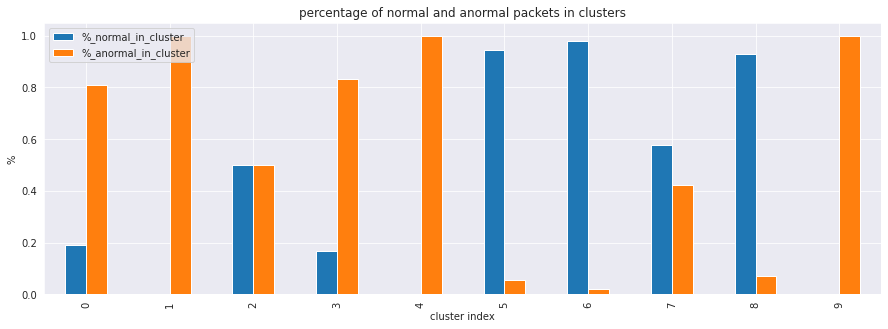

In [ ]:
cluster_summary[["%_normal_in_cluster","%_anormal_in_cluster"]].plot.bar(figsize=(15,5),title="percentage of normal and anormal packets in clusters",xlabel="cluster index",ylabel="%")
plt.show()

There we can see that the first cluster is made of plenty of normal data (93316) but it is only a small amount of the total number of data (20%). Thus if we tried to do predection with this setting, we will name data of the first cluster "anormal data" and we are going to face an huge number of false alarms. \
Then we think that this setting are not interresting enough. We decided to add more information ( -> more features ) about the data to allow the algorithm to find more clear differences between normal and anormal behaviour.\
As a consequence, we add content features to our study

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Basic and content features

As we said we add content features to our study

In [ ]:
continous_basic_content_feature = X[["duration","src_bytes","dst_bytes","wrong_fragment","urgent","hot","num_failed_logins","num_compromised","num_root","num_file_creations","num_shells","num_access_files","num_outbound_cmds"]]
continous_basic_content_feature.head()

,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,num_compromised,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds
0,0,181,5450,0,0,0,0,0,0,0,0,0,0
1,0,239,486,0,0,0,0,0,0,0,0,0,0
2,0,235,1337,0,0,0,0,0,0,0,0,0,0
3,0,219,1337,0,0,0,0,0,0,0,0,0,0
4,0,217,2032,0,0,0,0,0,0,0,0,0,0


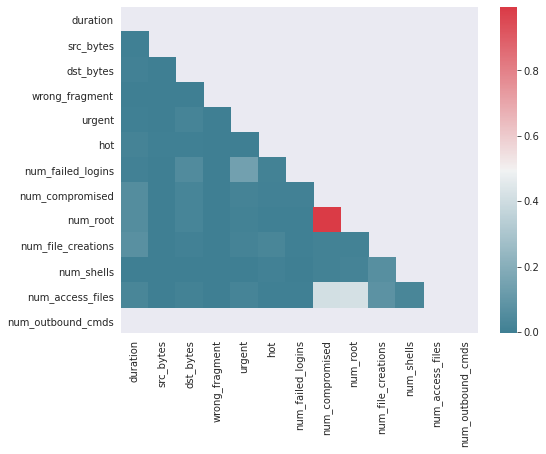

In [ ]:
corr_basic_content_feature = continous_basic_content_feature.corr()
plot_corr(corr_basic_content_feature)

strong correlation between columns "num root" and "num compromised". Thus we drop one of them -> num_root

In [ ]:
continous_basic_content_feature.drop(columns=["num_root"])
#we scale the data
continous_basic_content_features_centered = pd.DataFrame(scale(continous_basic_content_feature),columns = continous_basic_content_feature.columns)
continous_basic_content_features_centered.describe()

,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,num_compromised,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds
count,4.940210e+05,4.940210e+05,4.940210e+05,4.940210e+05,4.940210e+05,4.940210e+05,4.940210e+05,4.940210e+05,4.940210e+05,4.940210e+05,4.940210e+05,4.940210e+05,494021.0
mean,-3.625574e-14,-1.320064e-14,-5.498890e-14,-6.073146e-15,-1.529804e-14,-6.957988e-14,-8.038565e-14,-1.113045e-14,-1.364308e-14,1.653658e-14,2.616765e-14,3.418218e-14,0.0
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,0.0
min,-6.779172e-02,-3.061686e-03,-2.628733e-02,-4.772019e-02,-2.571468e-03,-4.413591e-02,-9.782185e-03,-5.678684e-03,-5.640012e-03,-1.123208e-02,-9.918975e-03,-2.763182e-02,0.0
25%,-6.779172e-02,-3.016149e-03,-2.628733e-02,-4.772019e-02,-2.571468e-03,-4.413591e-02,-9.782185e-03,-5.678684e-03,-5.640012e-03,-1.123208e-02,-9.918975e-03,-2.763182e-02,0.0
50%,-6.779172e-02,-2.535486e-03,-2.628733e-02,-4.772019e-02,-2.571468e-03,-4.413591e-02,-9.782185e-03,-5.678684e-03,-5.640012e-03,-1.123208e-02,-9.918975e-03,-2.763182e-02,0.0
75%,-6.779172e-02,-2.017381e-03,-2.628733e-02,-4.772019e-02,-2.571468e-03,-4.413591e-02,-9.782185e-03,-5.678684e-03,-5.640012e-03,-1.123208e-02,-9.918975e-03,-2.763182e-02,0.0
max,8.234740e+01,7.016400e+02,1.560110e+02,2.220663e+01,5.444371e+02,3.831404e+01,3.221639e+02,4.915630e+02,4.933575e+02,2.903977e+02,1.814783e+02,2.192607e+02,0.0


"num outbounds cmds" column is made of 0. It adds no information. Thus we dropp it

In [ ]:
continous_basic_content_features_centered.drop(columns=["num_outbound_cmds"])

,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,num_compromised,num_root,num_file_creations,num_shells,num_access_files
0,-0.067792,-0.002879,0.138664,-0.04772,-0.002571,-0.044136,-0.009782,-0.005679,-0.00564,-0.011232,-0.009919,-0.027632
1,-0.067792,-0.002820,-0.011578,-0.04772,-0.002571,-0.044136,-0.009782,-0.005679,-0.00564,-0.011232,-0.009919,-0.027632
2,-0.067792,-0.002824,0.014179,-0.04772,-0.002571,-0.044136,-0.009782,-0.005679,-0.00564,-0.011232,-0.009919,-0.027632
3,-0.067792,-0.002840,0.014179,-0.04772,-0.002571,-0.044136,-0.009782,-0.005679,-0.00564,-0.011232,-0.009919,-0.027632
4,-0.067792,-0.002842,0.035214,-0.04772,-0.002571,-0.044136,-0.009782,-0.005679,-0.00564,-0.011232,-0.009919,-0.027632
...,...,...,...,...,...,...,...,...,...,...,...,...
494016,-0.067792,-0.002748,0.030644,-0.04772,-0.002571,-0.044136,-0.009782,-0.005679,-0.00564,-0.011232,-0.009919,-0.027632
494017,-0.067792,-0.002776,0.042902,-0.04772,-0.002571,-0.044136,-0.009782,-0.005679,-0.00564,-0.011232,-0.009919,-0.027632
494018,-0.067792,-0.002856,0.010032,-0.04772,-0.002571,-0.044136,-0.009782,-0.005679,-0.00564,-0.011232,-0.009919,-0.027632
494019,-0.067792,-0.002767,0.010032,-0.04772,-0.002571,-0.044136,-0.009782,-0.005679,-0.00564,-0.011232,-0.009919,-0.027632


We run our Kmean algorithm with clusters number between 3 and 40. Then we will use the elbow curve to find the proper Kmean settings in that case

3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


[4517500.550536748,
 4038211.0981171876,
 3566011.596733588,
 3144079.368414329,
 2694824.13219135,
 2274445.5847637327,
 1885090.406779039,
 1504939.7092873512,
 1163637.3946921458,
 830329.5233433755,
 706057.6148951076,
 596998.0590384764,
 519009.26584305614,
 453057.1144352724,
 398565.607998971,
 362446.9050703288,
 322798.1400088812,
 289153.0234257868,
 263348.12260698585,
 238722.1932357103,
 219975.92603810047,
 200407.69155908836,
 181180.98221173463,
 167651.72871470108,
 156363.24062474843,
 134133.86555576505,
 126179.78723389606,
 112543.68622353813,
 104941.47802301926,
 95885.25499512615,
 89302.70693075935,
 83275.43775181446,
 74950.14060349215,
 68618.24218365832,
 65310.76428831604,
 58905.04528444295,
 55493.344462106084]

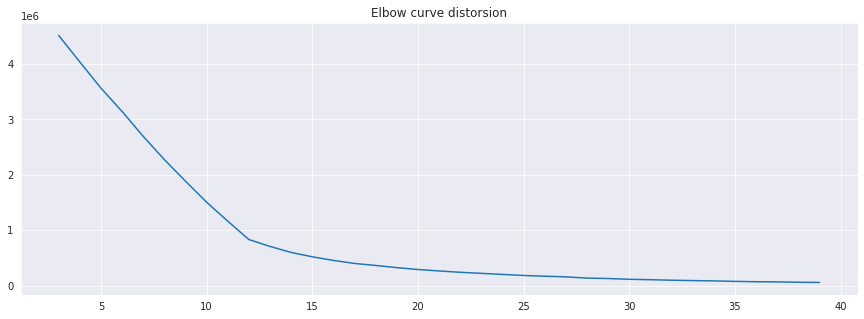

In [ ]:
number_of_clusters = np.arange(3,40)
number_init = 15
Kmeans_model(continous_basic_content_features_centered,number_of_clusters,number_init)

According to the elbow curve plot, **12** clusters is sufficient

We dive deeper into clustters information in order to highlight unproper behaviours in our clusters.

In [ ]:
NB_clusters = 12
model = KMeans(n_clusters=NB_clusters, n_init=20)
model.fit(continous_basic_content_features_centered)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=12, n_init=20, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [ ]:
model_labels = model.labels_
cluster_summary = pd.DataFrame(pd.get_dummies(model_labels).sum(), columns=["Nb_data_in_cluster"])
cluster_summary["Nb_normal_in_cluster"] = kmean_label_study(data["label"],model_labels,NB_clusters)
cluster_summary["Nb_anormal_in_cluster"] = (cluster_summary["Nb_data_in_cluster"] - cluster_summary["Nb_normal_in_cluster"])
cluster_summary["%_normal_in_cluster"] = kmean_label_study(data["label"],model_labels,NB_clusters)/cluster_summary["Nb_data_in_cluster"]
cluster_summary["%_anormal_in_cluster"] = (cluster_summary["Nb_data_in_cluster"] - cluster_summary["Nb_normal_in_cluster"])/cluster_summary["Nb_data_in_cluster"]

In [ ]:
cluster_summary.head(NB_clusters)

,Nb_data_in_cluster,Nb_normal_in_cluster,Nb_anormal_in_cluster,%_normal_in_cluster,%_anormal_in_cluster
0,491009,95701.0,395308.0,0.194907,0.805093
1,2,2.0,0.0,1.000000,0.000000
2,1,0.0,1.0,0.000000,1.000000
3,427,139.0,288.0,0.325527,0.674473
4,51,43.0,8.0,0.843137,0.156863
5,2,1.0,1.0,0.500000,0.500000
6,970,0.0,970.0,0.000000,1.000000
7,12,11.0,1.0,0.916667,0.083333
8,446,440.0,6.0,0.986547,0.013453
9,62,9.0,53.0,0.145161,0.854839


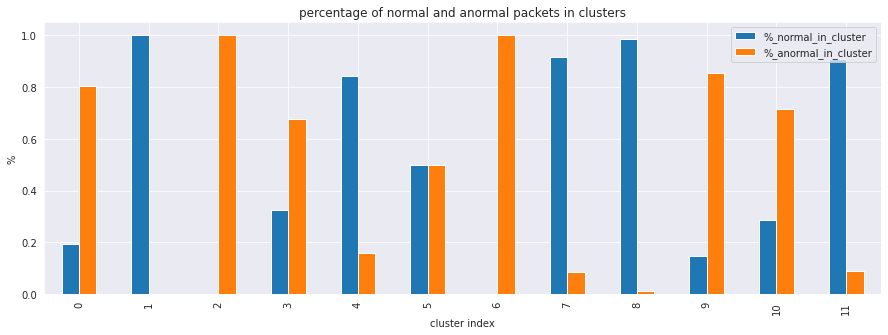

In [ ]:
cluster_summary[["%_normal_in_cluster","%_anormal_in_cluster"]].plot.bar(figsize=(15,5),title="percentage of normal and anormal packets in clusters",xlabel="cluster index",ylabel="%")
plt.show()

It is the same problem as before with the basic features. As we can see the first cluster is made of plenty of "normal features" (95701) but it represents only a small part of the cluster (~20%). \
Thus if we tried to do predection with this setting, we will name data of the first cluster "anormal data" and we are going to face an huge number of false alarms. \
Then we think that this setting are also not interresting enough. We decided to add more information ( -> more features ) about the data to allow the algorithm to find more clear differences between normal and anormal behaviour.\
As a consequence, we use all continous data from the KDD-99 dataset.




---



### All continous features

In [ ]:
continous_feature = X[["count","srv_count","serror_rate","srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate","diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count","dst_host_serror_rate","dst_host_srv_serror_rate","dst_host_rerror_rate","dst_host_srv_rerror_rate","dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_srv_diff_host_rate","dst_host_same_src_port_rate","duration","src_bytes","dst_bytes","wrong_fragment","urgent","hot","num_failed_logins","num_compromised","num_root","num_file_creations","num_shells","num_access_files","num_outbound_cmds"]]
continous_basic_content_feature.head()

,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,num_compromised,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds
0,0,181,5450,0,0,0,0,0,0,0,0,0,0
1,0,239,486,0,0,0,0,0,0,0,0,0,0
2,0,235,1337,0,0,0,0,0,0,0,0,0,0
3,0,219,1337,0,0,0,0,0,0,0,0,0,0
4,0,217,2032,0,0,0,0,0,0,0,0,0,0


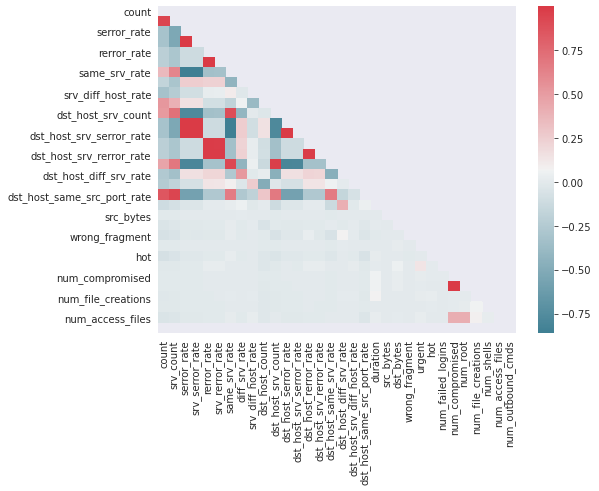

In [ ]:
corr_continous_feature = continous_feature.corr()
plot_corr(corr_continous_feature)

We can see there that there are no correlation between traffic features and the other features. We decided to plot a correlation of the traffic features only to see if interresting things could be find.

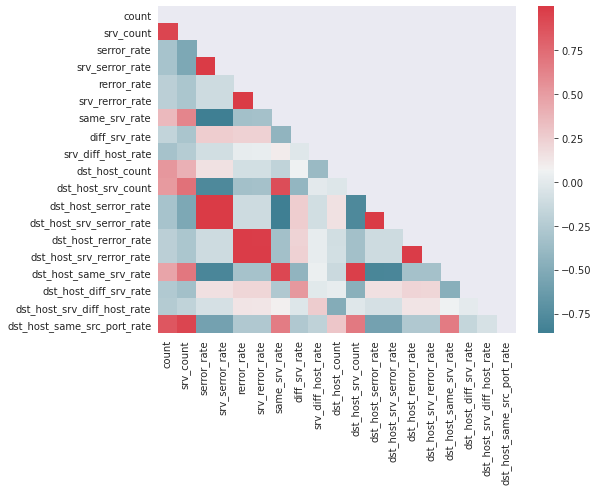

In [ ]:
corr_traffic_features = traffic_features.corr()
plot_corr(corr_traffic_features)

For now, we decided not to study traffic features correlation. Nevertheless, we think that we are going to do it for the metrics evaluation. \
Then we decided to drop the "num_outbound_cmds" that adds no more information because there are only zeros in this column.

In [ ]:
#we scale the data
continous_features_centered = pd.DataFrame(scale(continous_feature),columns = continous_feature.columns)
continous_features_centered.describe()

,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_srv_diff_host_rate,dst_host_same_src_port_rate,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,num_compromised,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds
count,4.940210e+05,4.940210e+05,4.940210e+05,4.940210e+05,4.940210e+05,4.940210e+05,4.940210e+05,4.940210e+05,4.940210e+05,4.940210e+05,4.940210e+05,4.940210e+05,4.940210e+05,4.940210e+05,4.940210e+05,4.940210e+05,4.940210e+05,4.940210e+05,4.940210e+05,4.940210e+05,4.940210e+05,4.940210e+05,4.940210e+05,4.940210e+05,4.940210e+05,4.940210e+05,4.940210e+05,4.940210e+05,4.940210e+05,4.940210e+05,4.940210e+05,494021.0
mean,-1.203781e-12,9.679063e-13,-1.143631e-13,8.831368e-13,-4.453581e-13,-3.240810e-13,2.946455e-13,1.474275e-13,4.828077e-13,-7.353653e-13,1.953080e-13,2.263813e-13,3.603748e-13,6.990594e-13,-9.654619e-14,3.799918e-13,-1.392772e-13,2.700207e-13,7.581150e-13,-3.625574e-14,-1.320064e-14,-5.498890e-14,-6.073146e-15,-1.529804e-14,-6.957988e-14,-8.038565e-14,-1.113045e-14,-1.364308e-14,1.653658e-14,2.616765e-14,3.418218e-14,0.0
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,0.0
min,-1.558949e+00,-1.189118e+00,-4.640898e-01,-4.635205e-01,-2.479605e-01,-2.486313e-01,-2.039077e+00,-2.552434e-01,-2.036331e-01,-3.590542e+00,-1.779188e+00,-4.644176e-01,-4.632024e-01,-2.520395e-01,-2.494640e-01,-1.834994e+00,-2.828667e-01,-1.586293e-01,-1.250621e+00,-6.779172e-02,-3.061686e-03,-2.628733e-02,-4.772019e-02,-2.571468e-03,-4.413591e-02,-9.782185e-03,-5.678684e-03,-5.640012e-03,-1.123208e-02,-9.918975e-03,-2.763182e-02,0.0
25%,-1.010033e+00,-1.148521e+00,-4.640898e-01,-4.635205e-01,-2.479605e-01,-2.486313e-01,5.369874e-01,-2.552434e-01,-2.036331e-01,3.479668e-01,-1.345391e+00,-4.644176e-01,-4.632024e-01,-2.520395e-01,-2.494640e-01,-8.368938e-01,-2.828667e-01,-1.586293e-01,-1.250621e+00,-6.779172e-02,-3.016149e-03,-2.628733e-02,-4.772019e-02,-2.571468e-03,-4.413591e-02,-9.782185e-03,-5.678684e-03,-5.640012e-03,-1.123208e-02,-9.918975e-03,-2.763182e-02,0.0
50%,8.337633e-01,8.813380e-01,-4.640898e-01,-4.635205e-01,-2.479605e-01,-2.486313e-01,5.369874e-01,-2.552434e-01,-2.036331e-01,3.479668e-01,6.255576e-01,-4.644176e-01,-4.632024e-01,-2.520395e-01,-2.494640e-01,5.993962e-01,-2.828667e-01,-1.586293e-01,8.270476e-01,-6.779172e-02,-2.535486e-03,-2.628733e-02,-4.772019e-02,-2.571468e-03,-4.413591e-02,-9.782185e-03,-5.678684e-03,-5.640012e-03,-1.123208e-02,-9.918975e-03,-2.763182e-02,0.0
75%,8.384549e-01,8.853977e-01,-4.640898e-01,-4.635205e-01,-2.479605e-01,-2.486313e-01,5.369874e-01,-2.552434e-01,-2.036331e-01,3.479668e-01,6.255576e-01,-4.644176e-01,-4.632024e-01,-2.520395e-01,-2.494640e-01,5.993962e-01,8.323588e-02,-1.586293e-01,8.270476e-01,-6.779172e-02,-2.017381e-03,-2.628733e-02,-4.772019e-02,-2.571468e-03,-4.413591e-02,-9.782185e-03,-5.678684e-03,-5.640012e-03,-1.123208e-02,-9.918975e-03,-2.763182e-02,0.0
max,8.384549e-01,8.853977e-01,2.162536e+00,2.161040e+00,4.069396e+00,4.058989e+00,5.369874e-01,1.190941e+01,6.818971e+00,3.479668e-01,6.255576e-01,2.163063e+00,2.162027e+00,4.084676e+00,4.095715e+00,5.993962e-01,8.869697e+00,2.357583e+01,8.270476e-01,8.234740e+01,7.016400e+02,1.560110e+02,2.220663e+01,5.444371e+02,3.831404e+01,3.221639e+02,4.915630e+02,4.933575e+02,2.903977e+02,1.814783e+02,2.192607e+02,0.0


In [ ]:
continous_features_centered.drop(columns=["num_outbound_cmds"])

,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_srv_diff_host_rate,dst_host_same_src_port_rate,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,num_compromised,num_root,num_file_creations,num_shells,num_access_files
0,-1.521417,-1.156640,-0.464090,-0.463520,-0.24796,-0.248631,0.536987,-0.255243,-0.203633,-3.451536,-1.694315,-0.464418,-0.463202,-0.25204,-0.249464,0.599396,-0.282867,-0.158629,-1.022077,-0.067792,-0.002879,0.138664,-0.04772,-0.002571,-0.044136,-0.009782,-0.005679,-0.00564,-0.011232,-0.009919,-0.027632
1,-1.521417,-1.156640,-0.464090,-0.463520,-0.24796,-0.248631,0.536987,-0.255243,-0.203633,-3.297085,-1.600011,-0.464418,-0.463202,-0.25204,-0.249464,0.599396,-0.282867,-0.158629,-1.146737,-0.067792,-0.002820,-0.011578,-0.04772,-0.002571,-0.044136,-0.009782,-0.005679,-0.00564,-0.011232,-0.009919,-0.027632
2,-1.521417,-1.156640,-0.464090,-0.463520,-0.24796,-0.248631,0.536987,-0.255243,-0.203633,-3.142633,-1.505707,-0.464418,-0.463202,-0.25204,-0.249464,0.599396,-0.282867,-0.158629,-1.188291,-0.067792,-0.002824,0.014179,-0.04772,-0.002571,-0.044136,-0.009782,-0.005679,-0.00564,-0.011232,-0.009919,-0.027632
3,-1.530800,-1.164760,-0.464090,-0.463520,-0.24796,-0.248631,0.536987,-0.255243,-0.203633,-2.988182,-1.411403,-0.464418,-0.463202,-0.25204,-0.249464,0.599396,-0.282867,-0.158629,-1.188291,-0.067792,-0.002840,0.014179,-0.04772,-0.002571,-0.044136,-0.009782,-0.005679,-0.00564,-0.011232,-0.009919,-0.027632
4,-1.530800,-1.164760,-0.464090,-0.463520,-0.24796,-0.248631,0.536987,-0.255243,-0.203633,-2.833731,-1.317100,-0.464418,-0.463202,-0.25204,-0.249464,0.599396,-0.282867,-0.158629,-1.209067,-0.067792,-0.002842,0.035214,-0.04772,-0.002571,-0.044136,-0.009782,-0.005679,-0.00564,-0.011232,-0.009919,-0.027632
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494016,-1.540183,-1.168819,-0.464090,-0.463520,-0.24796,-0.248631,0.536987,-0.255243,2.605409,-2.262261,0.625558,-0.464418,-0.436950,-0.25204,-0.249464,0.599396,-0.282867,1.028094,-1.229844,-0.067792,-0.002748,0.030644,-0.04772,-0.002571,-0.044136,-0.009782,-0.005679,-0.00564,-0.011232,-0.009919,-0.027632
494017,-1.530800,-1.164760,-0.464090,-0.463520,-0.24796,-0.248631,0.536987,-0.255243,-0.203633,-3.497871,0.625558,-0.464418,-0.436950,-0.25204,-0.249464,0.599396,-0.282867,1.028094,-0.897417,-0.067792,-0.002776,0.042902,-0.04772,-0.002571,-0.044136,-0.009782,-0.005679,-0.00564,-0.011232,-0.009919,-0.027632
494018,-1.530800,-1.116043,-0.017563,-0.174819,-0.24796,-0.248631,0.536987,-0.255243,0.990210,-3.343420,0.625558,-0.306769,-0.436950,-0.25204,-0.249464,0.599396,-0.282867,1.028094,-1.125961,-0.067792,-0.002856,0.010032,-0.04772,-0.002571,-0.044136,-0.009782,-0.005679,-0.00564,-0.011232,-0.009919,-0.027632
494019,-1.530800,-1.140401,-0.464090,-0.463520,-0.24796,-0.248631,0.536987,-0.255243,0.990210,-3.188969,0.625558,-0.359318,-0.436950,-0.25204,-0.249464,0.599396,-0.282867,1.028094,-1.167514,-0.067792,-0.002767,0.010032,-0.04772,-0.002571,-0.044136,-0.009782,-0.005679,-0.00564,-0.011232,-0.009919,-0.027632


3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


[9523052.922311813,
 8271996.6437176615,
 7353705.145356159,
 6836961.046636444,
 6300066.544719274,
 5818350.441359954,
 5465341.187991555,
 5069542.917861838,
 4523083.171299588,
 4103575.7400821163,
 3830722.7693025908,
 3417319.5123983123,
 3008868.217418526,
 2715190.481639977,
 2426897.683620761,
 2178191.600974223,
 1837639.7723830438,
 1644409.5920636076,
 1461452.3668307343,
 1337238.683013697,
 1227769.4668512386,
 1141619.5625486285,
 1074301.101300232,
 1051248.1276964364,
 976141.264014523,
 939832.7221592276,
 884821.3050245742,
 850594.8398841239,
 817051.4603635039,
 794020.8756785988,
 774044.8182857702,
 732729.636313484,
 712107.3591811657,
 679103.4539161364,
 648016.6439507441,
 633475.9314773441,
 606221.2937646249]

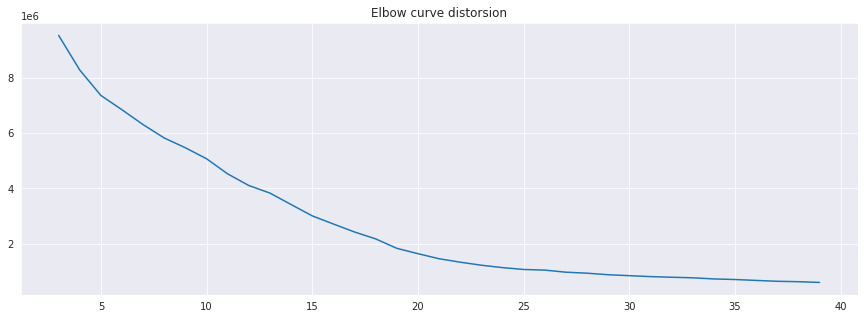

In [ ]:
number_of_clusters = np.arange(3,40)
number_init = 15
Kmeans_model(continous_features_centered,number_of_clusters,number_init)

According to the elbow curve plot, **25** clusters is sufficient

We dive deeper into clustters information in order to highlight unproper behaviours in our clusters.

In [ ]:
NB_clusters = 25
model = KMeans(n_clusters=NB_clusters, n_init=20)
model.fit(continous_features_centered)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=25, n_init=20, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [ ]:
model_labels = model.labels_
cluster_summary = pd.DataFrame(pd.get_dummies(model_labels).sum(), columns=["Nb_data_in_cluster"])
cluster_summary["Nb_normal_in_cluster"] = kmean_label_study(data["label"],model_labels,NB_clusters)
cluster_summary["Nb_anormal_in_cluster"] = (cluster_summary["Nb_data_in_cluster"] - cluster_summary["Nb_normal_in_cluster"])
cluster_summary["%_normal_in_cluster"] = kmean_label_study(data["label"],model_labels,NB_clusters)/cluster_summary["Nb_data_in_cluster"]
cluster_summary["%_anormal_in_cluster"] = (cluster_summary["Nb_data_in_cluster"] - cluster_summary["Nb_normal_in_cluster"])/cluster_summary["Nb_data_in_cluster"]

In [ ]:
cluster_summary.head(NB_clusters)

,Nb_data_in_cluster,Nb_normal_in_cluster,Nb_anormal_in_cluster,%_normal_in_cluster,%_anormal_in_cluster
0,42368,40428.0,1940.0,0.954211,0.045789
1,86633,13.0,86620.0,0.000150,0.999850
2,280662,36.0,280626.0,0.000128,0.999872
3,21340,113.0,21227.0,0.005295,0.994705
4,970,0.0,970.0,0.000000,1.000000
5,36995,35742.0,1253.0,0.966131,0.033869
6,3,3.0,0.0,1.000000,0.000000
7,51,43.0,8.0,0.843137,0.156863
8,4489,4297.0,192.0,0.957229,0.042771
9,2,2.0,0.0,1.000000,0.000000


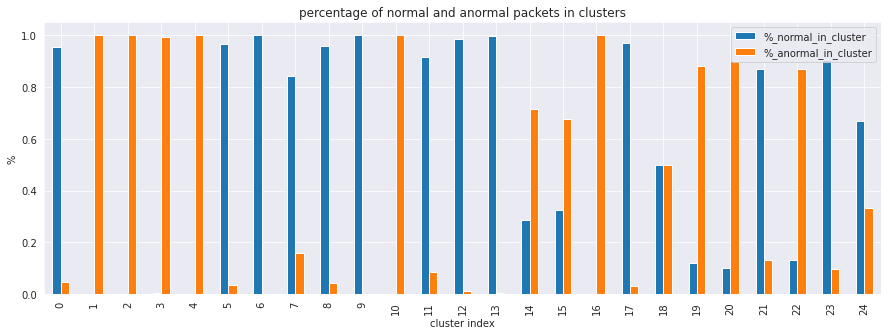

In [ ]:
cluster_summary[["%_normal_in_cluster","%_anormal_in_cluster"]].plot.bar(figsize=(15,5),title="percentage of normal and anormal packets in clusters",xlabel="cluster index",ylabel="%")
plt.show()

We can see there that the problem with a big dataset made of lot of normal data is corrected. On top of that big clusters like cluster 0, 1, 2, 5 are made of predominant type of data. For instance, the number 2, the the biggest one, is mostly made of anormal data (more than 99%). Thus we can easily name this cluster as a anormal cluster without thinking about to many false alarms. \
Now, the tricky part of the study will be smallest clusters like the 15. It is made of 32% of normal data and contains 426 data. The questions are "Can we assign this clusters to a certain type of behaviour ?", "Do we really care about small clusters or can we overlook them ?". 


\



To conclude the study on Kmean algorithm setting we can say that :



*   We need all our continous data to find proper setting. Maybe it could be interresting to add categorical data that are one hot encoded to find more accurate setting.
*   **25 is a proper number of clusters for our kmean algorithm**





---



### Other bunch of code

In [ ]:
tcp = basic_feature.loc[basic_feature["protocol_type"]==0]
udp = basic_feature.loc[basic_feature["protocol_type"]==1]
icmp = basic_feature.loc[basic_feature["protocol_type"]==2]

In [ ]:
tcp_size = tcp.shape[0]
udp_size = udp.shape[0]
icmp_size = icmp.shape[0]

normal_tcp = tcp.loc[tcp["label"]==0].shape[0]
normal_udp = udp.loc[udp["label"]==0].shape[0]
normal_icmp = icmp.loc[icmp["label"]==0].shape[0]

print("number of data in tcp : ",tcp_size)
print("number of data in udp : ",udp_size)
print("number of data in icmp : ",icmp_size)
print()
print("percentage of normal label in tcp : ", normal_tcp/tcp_size)
print("percentage of normal label in udp : ",normal_udp/udp_size)
print("percentage of normal label in icmp : ",normal_icmp/icmp_size)



number of data in tcp :  190065
number of data in udp :  20354
number of data in icmp :  283602

percentage of normal label in tcp :  0.4041406887117565
percentage of normal label in udp :  0.9421735285447578
percentage of normal label in icmp :  0.004541575870409941
